#newTimeSeriesNN -- 06/20 currently uses noisey sinusoid dataset
generated internally.

Forecast Time Series Data with LSTMs in Keras using
recurrent LMSTMSs.
Time Series data introduces a “hard dependency” on previous time 
steps, so the assumption that independence of observations 
doesn’t hold. What are some of the properties that a Time 
Series can have?
Stationarity, seasonality, and autocorrelation are some of 
the properties.
A Times Series is said to be stationary when the mean 
and variance remain constant over time. A Time-Series 
has a trend if the mean is varying over time. Often 
you can eliminate it and make the series stationary by 
applying log transformation(s).
Seasonality refers to the phenomenon of variations at 
specific time-frames. eg people buying more Christmas 
trees during Christmas (who would’ve thought). 
A common approach to eliminating seasonality is to use 
differencing.
Autocorrelation refers to the correlation between the 
current value with a copy from a previous time (lag).
Why we would want to seasonality, trend and have a 
stationary Time Series? 
This is required data preprocessing step for Time Series 
forecasting with classical methods like ARIMA models. So, 
we’ll do our modeling using Recurrent Neural Networks.

Problems with Classical RNNs
Unrolled Neural Networks can get very deep,
which creates problems for the gradient calculations. 
The weights can become very small ( Vanishing gradient problem)
or very large ( Exploding gradient problem).
Classic RNNs also have a problem with their memory 
(long-term dependencies), too. The begging of the 
sequences we use for training tends to be “forgotten” 
because of the overwhelming effect of more recent states.
In practice, those problems are solved by using gated RNNs. 
They can store information for later use, much like 
having a memory. Reading, writing, and deleting from the
memory are learned from the data. The two most commonly 
used gated RNNs are Long Short-Term Memory Networks and 
Gated Recurrent Unit Neural Networks.

ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.

In [1]:
#https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

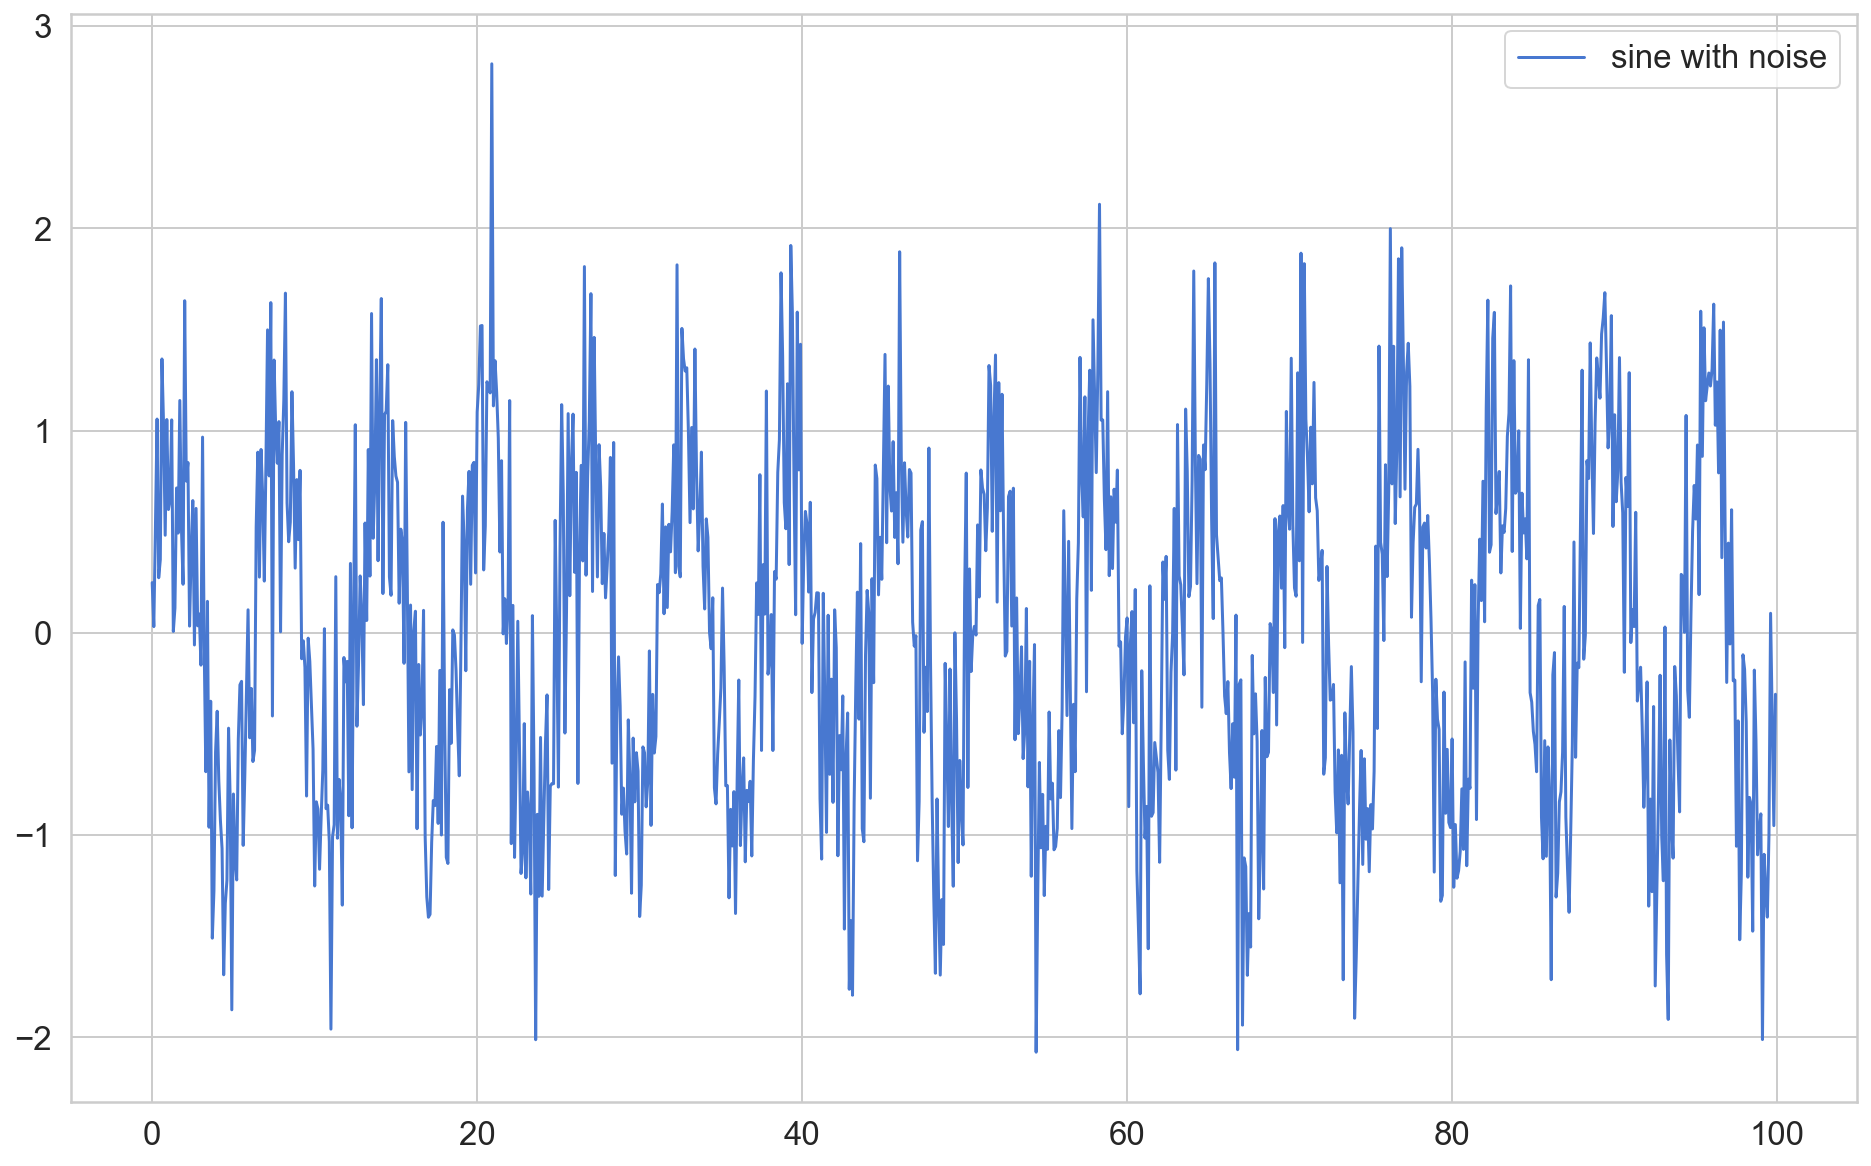

In [2]:
'''generate 1,000 values from the sine function and use that as training data. 
But, we’ll add a little noise to it'''

time = np.arange(0, 100, 0.1)
'''numpy.arange([start, ]stop, [step, ]dtype=None)
returns evenly spaced values within a given interval'''
sin = np.sin(time) + np.random.normal(scale=0.5, size=len(time))

plt.plot(time, sin, label="sine with noise")
plt.legend()

In [3]:
#split it into training and test data
df = pd.DataFrame(dict(sine=sin), index=time, columns=['sine'])
'''class pandas.DataFrame(data=None, 
index: Optional[Collection] = None, 
columns: Optional[Collection] = None, 
dtype: Optional[Union[str, numpy.dtype, ExtensionDtype]] = None, copy: bool = False)

Two-dimensional, size-mutable, potentially heterogeneous tabular data.
Data structure also contains labeled axes (rows and columns). 
Arithmetic operations align on both row and column labels. 
Can be thought of as a dict-like container for Series objects. 
The primary pandas data structure.

Parameters
datandarray (structured or homogeneous), Iterable, dict, or DataFrame
Dict can contain Series, arrays, constants, or list-like objects.
If data is a dict, column order follows insertion-order for Python 3.6 and later.
If data is a list of dicts, column order follows insertion-order,Python 3.6 and later.

indexIndex or array-like
Index to use for resulting frame. Will default to RangeIndex if no 
indexing information part of input data and no index provided.

columnsIndex or array-like
Column labels to use for resulting frame. Will default to 
RangeIndex (0, 1, 2, …, n) if no column labels are provided.

dtypedtype, default None
Data type to force. Only a single dtype is allowed. If None, infer.

copybool, default False
Copy data from inputs. Only affects DataFrame / 2d ndarray input'''

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
'''iloc returns a Pandas Series when one row is selected, and a Pandas DataFrame 
when multiple rows are selected, or if any column in full is selected. 
To counter this, pass a single-valued list if you require DataFrame output.'''
print(len(train), len(test))

800 200


In [4]:
'''Preparing the data for Time Series forecasting (LSTMs in particular) can be 
tricky. Intuitively, we need to predict the value at the current time step by 
using the history ( n time steps from it). Here’s a generic function for job'''
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
#This function works with univariate (single feature) and multivariate 
#(multiple features) Time Series data.

In [5]:
#use a history of 10 time steps to make the sequences:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)

print(X_train.shape, y_train.shape)
'''We have sequences in the shape (samples, time_steps, features)'''

(790, 10, 1) (790,)


'We have sequences in the shape (samples, time_steps, features)'

In [6]:
X_train[0]
y_train[0]

0.6097621384016654

In [7]:
'''Use the LSTM layer in a sequential model to make predictions:'''
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
'''units 
Positive integer, dimensionality of the output space. 
activation 
Activation function to use. Default: hyperbolic tangent (tanh). 
If you pass None, no activation is applied (ie. "linear" activation: a(x) = x). 
recurrent_activation 
Activation function to use for the recurrent step. 
Default: sigmoid (sigmoid). 
If you pass None, no activation is applied (ie. "linear" activation: a(x) = x). 
use_bias 
Boolean (default True), whether the layer uses a bias vector. 
kernel_initializer 
Initializer for the kernel weights matrix, used for the linear 
transformation of the inputs. Default: glorot_uniform. 
recurrent_initializer 
Initializer for the recurrent_kernel weights matrix, used for 
the linear transformation of the recurrent state. Default: orthogonal. 
bias_initializer 
Initializer for the bias vector. Default: zeros. 
unit_forget_bias 
Boolean (default True). If True, add 1 to the bias of the 
forget gate at initialization. Setting it to true will also 
force bias_initializer="zeros". This is recommended in Jozefowicz et al.. 
kernel_regularizer 
Regularizer function applied to the kernel weights matrix. Default: None. 
recurrent_regularizer 
Regularizer function applied to the recurrent_kernel weights matrix. Default: None. 
bias_regularizer 
Regularizer function applied to the bias vector. Default: None. 
activity_regularizer 
Regularizer function applied to the output of the layer (its "activation"). Default: None. 
kernel_constraint 
Constraint function applied to the kernel weights matrix. Default: None. 
recurrent_constraint 
Constraint function applied to the recurrent_kernel weights matrix. Default: None. 
bias_constraint 
Constraint function applied to the bias vector. Default: None. 
dropout 
Float between 0 and 1. Fraction of the units to drop for the linear 
transformation of the inputs. Default: 0. 
recurrent_dropout 
Float between 0 and 1. Fraction of the units to drop for the linear 
transformation of the recurrent state. Default: 0. 
implementation 
Implementation mode, either 1 or 2. Mode 1 will structure its 
operations as a larger number of smaller dot products and additions, 
whereas mode 2 will batch them into fewer, larger operations. 
These modes will have different performance profiles on different hardware 
and for different applications. Default: 2. 
return_sequences 
Boolean. Whether to return the last output. in the output sequence, 
or the full sequence. Default: False. 
return_state 
Boolean. Whether to return the last state in addition to the output. Default: False. 
go_backwards 
Boolean (default False). If True, process the input sequence backwards 
and return the reversed sequence. 
stateful 
Boolean (default False). If True, the last state for each sample at index i 
in a batch will be used as initial state for the sample of index i in 
the following batch. 
time_major 
The shape format of the inputs and outputs tensors. If True, the inputs and 
outputs will be in shape [timesteps, batch, feature], whereas in the False case, it will be [batch, timesteps, feature]. Using time_major = True is a bit more efficient because it avoids transposes at the beginning and end of the RNN calculation. However, most TensorFlow data is batch-major, so by default this function accepts input and emits output in batch-major form. 
unroll 
Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences. 

Call arguments:
inputs: A 3D tensor with shape [batch, timesteps, feature].
mask: Binary tensor of shape [batch, timesteps] indicating whether
a given timestep should be masked (optional, defaults to None).
training: Python boolean indicating whether the layer should 
behave in training mode or in inference mode. 
This argument is passed to the cell when calling it. 
This is only relevant if dropout or recurrent_dropout is used (optional, defaults to None).
initial_state: List of initial state tensors to be passed to the 
first call of the cell 
(optional, defaults to None which causes creation of zero-filled initial state tensors).'''
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)
'''The LSTM layer expects the number of time steps and the 
number of features to work properly. The rest of the model 
looks like a regular regression model.'''

'The LSTM layer expects the number of time steps and the \nnumber of features to work properly. The rest of the model \nlooks like a regular regression model.'

In [8]:
# Note:important thing to remember when training Time Series 
# models is to not shuffle the data

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 711 samples, validate on 79 samples
Epoch 1/30
711/711 [==============================] - 2s 3ms/sample - loss: 0.4394 - val_loss: 0.3740
Epoch 2/30
711/711 [==============================] - 0s 443us/sample - loss: 0.3324 - val_loss: 0.3310
Epoch 3/30
711/711 [==============================] - 0s 423us/sample - loss: 0.3219 - val_loss: 0.3254
Epoch 4/30
711/711 [==============================] - 0s 437us/sample - loss: 0.3199 - val_loss: 0.3217
Epoch 5/30
711/711 [==============================] - 0s 450us/sample - loss: 0.3184 - val_loss: 0.3191
Epoch 6/30
711/711 [==============================] - 0s 442us/sample - loss: 0.3173 - val_loss: 0.3171
Epoch 7/30
711/711 [==============================] - 0s 460us/sample - loss: 0.3165 - val_loss: 0.3154
Epoch 8/30
711/711 [==============================] - 0s 440us/sample - loss: 0.3157 - val_loss: 0.3140
Epoch 9/30
711/711 [==============================] - 0s 420us/sample - loss: 0.3150 - val_loss: 0.3126
Epoch 10/30
711/711 [

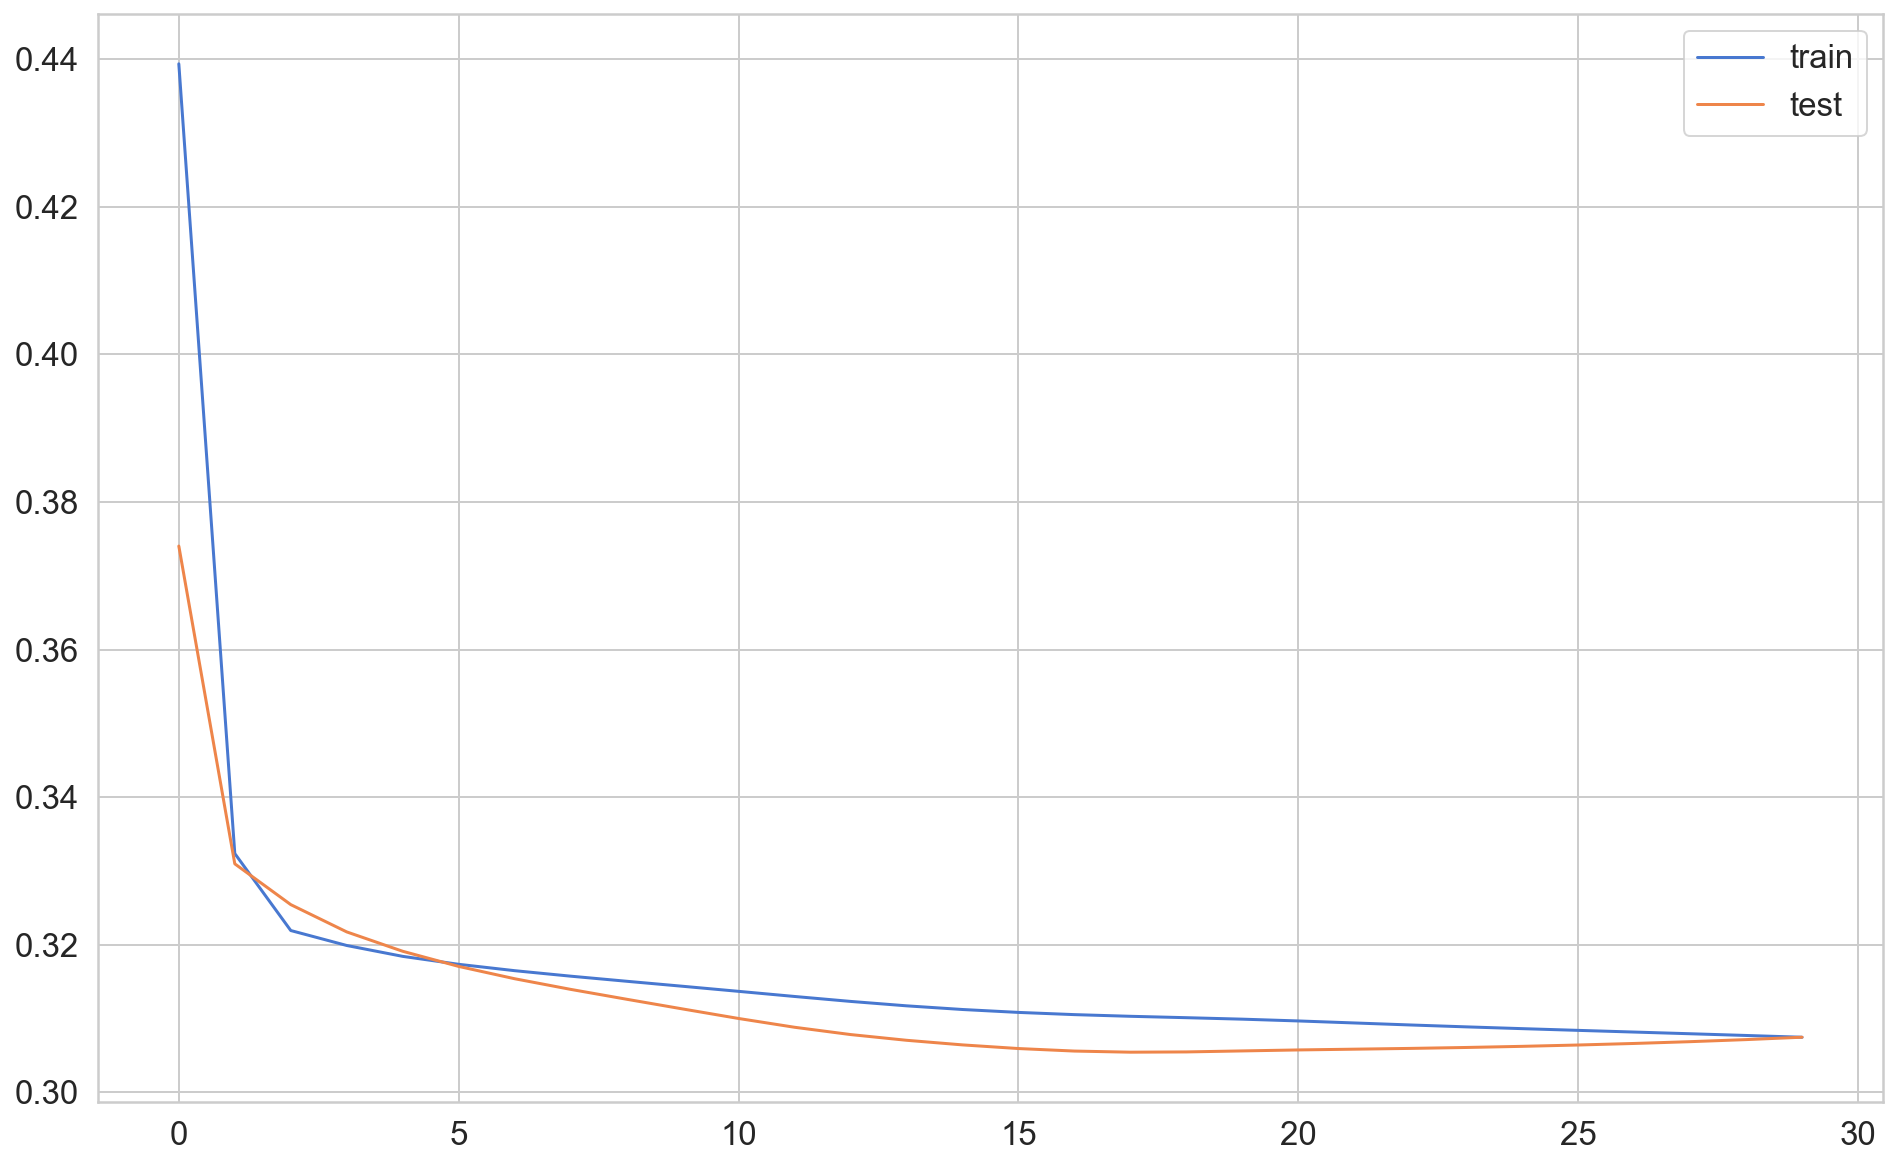

In [9]:
#Evaluation
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [10]:
# Make some predictions

y_pred = model.predict(X_test)

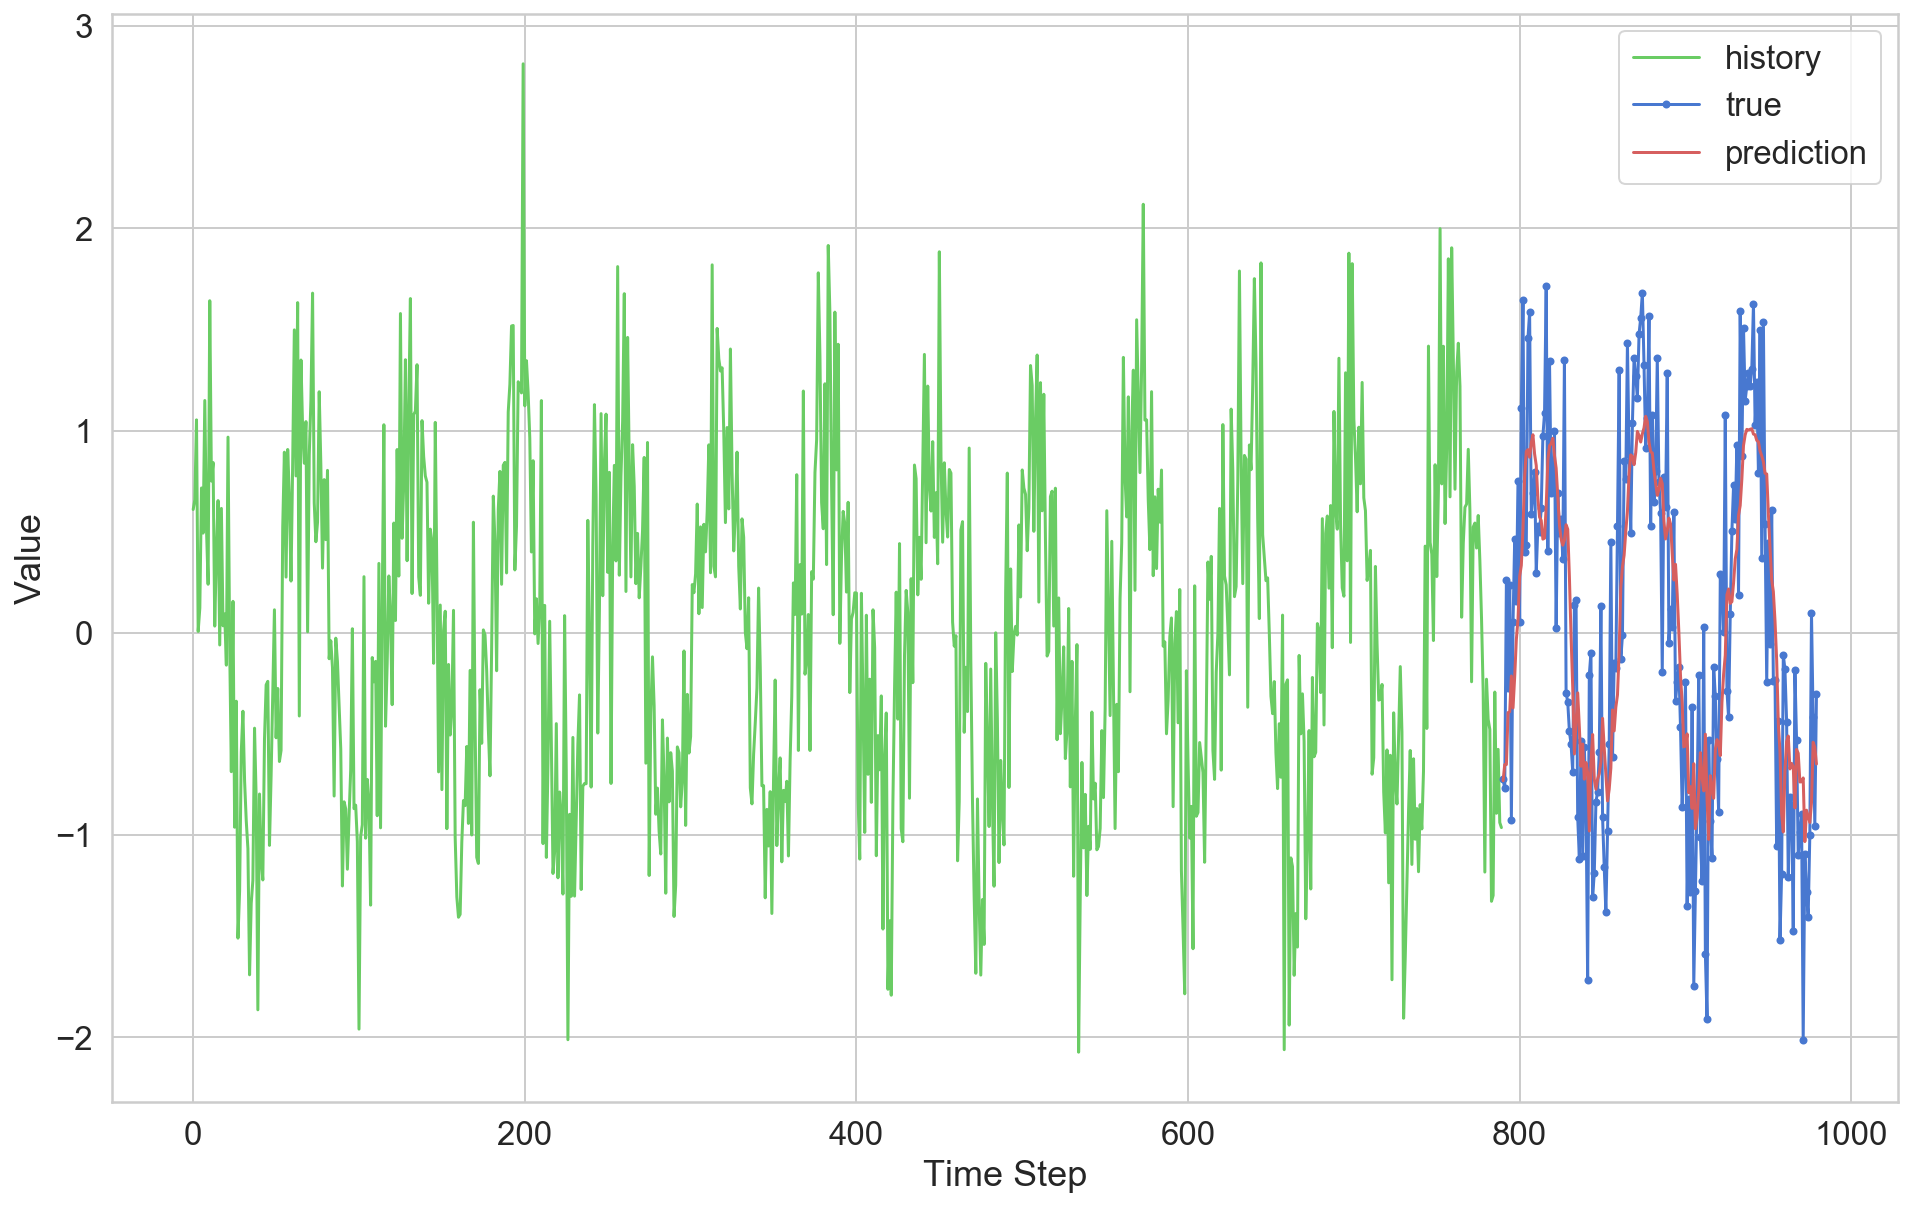

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

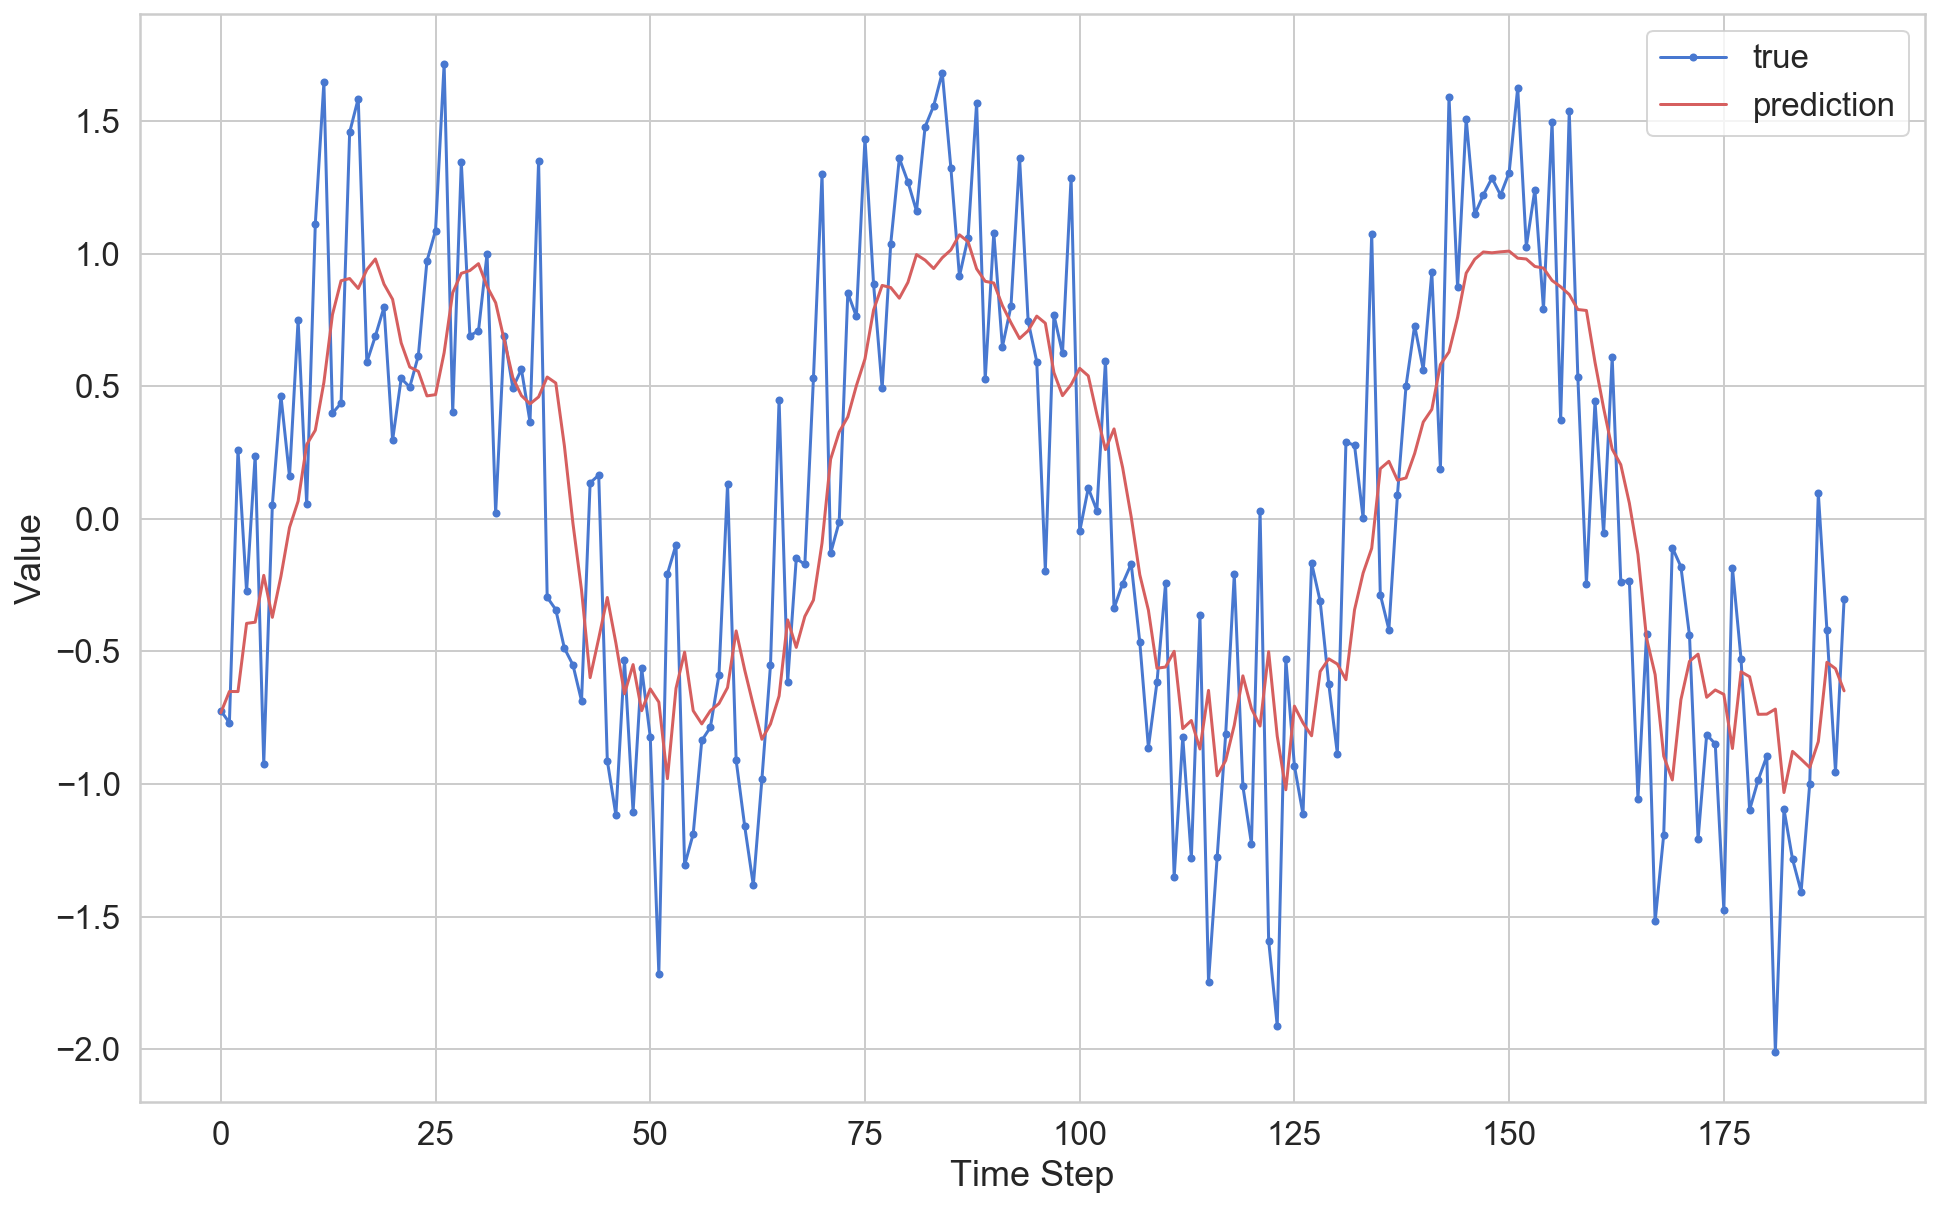

In [12]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();